# Swaps Pricing: Dual curve approach

In [1]:
import numpy as np
import pandas as pd
import QuantLib as ql
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image

In [2]:
calendar = ql.TARGET()
calculation_date = ql.Date(29,12,2017)
ql.Settings.instance().evaluationDate = calculation_date
settlementDays = 2
settlementDate = calendar.advance(calculation_date, ql.Period(settlementDays, ql.Days))

#Choose either 'Futures' or 'FRAs' 
#mid_term_instrument = 'Futures'
mid_term_instrument = 'FRAs'

mean_reversion_coefficient = 0.03
volatility = 0.511*0.01            #(0.511%)

enable_convexity_adjustment = True

#If false, you can skip to section 2
enable_OIS_dual_curve_stripping = True

# Issue solved. Consider CSA Coll Ccy = EUR, so discount curve is EONIA in Bloomberg. (collaretal = true)
collateral = True

Term structures

In [3]:
discountTermStructure = ql.RelinkableYieldTermStructureHandle()
forwardTermStructure = ql.RelinkableYieldTermStructureHandle()

## 1- Discount curve bootstraping: EONIA

In [4]:
OIS = pd.read_excel('Bloomberg data/EONIA/29 dec 2017/curve construction/Zero Rates Chart.xlsx')

In [5]:
OIS

,Term,Unit,Ticker,Bid,Ask,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq
0,1,DY,EONIA,-0.346000,-0.346000,NaN,0,0,-0.346000,-0.346000,Cash Rates,ACT/360,0
1,1,WK,EUSWE1Z,-0.362331,-0.333669,NaN,0,0,-0.362331,-0.333669,Swap Rates,ACT/360,1
2,2,WK,EUSWE2Z,-0.358043,-0.337957,NaN,0,0,-0.358043,-0.337957,Swap Rates,ACT/360,1
3,1,MO,EUSWEA,-0.353404,-0.336596,NaN,0,0,-0.353404,-0.336596,Swap Rates,ACT/360,1
4,2,MO,EUSWEB,-0.358243,-0.332757,NaN,0,0,-0.358243,-0.332757,Swap Rates,ACT/360,1
5,3,MO,EUSWEC,-0.350395,-0.338605,NaN,0,0,-0.350395,-0.338605,Swap Rates,ACT/360,1
6,4,MO,EUSWED,-0.348624,-0.340776,NaN,0,0,-0.348624,-0.340776,Swap Rates,ACT/360,1
7,5,MO,EUSWEE,-0.348972,-0.339628,NaN,0,0,-0.348972,-0.339628,Swap Rates,ACT/360,1
8,6,MO,EUSWEF,-0.350445,-0.337555,NaN,0,0,-0.350445,-0.337555,Swap Rates,ACT/360,1
9,7,MO,EUSWEG,-0.349348,-0.336651,NaN,0,0,-0.349348,-0.336651,Swap Rates,ACT/360,1


In [6]:
OIS['Unit'].replace({'DY': ql.Days, 'WK': ql.Weeks,'MO': ql.Months, 'YR': ql.Years}, inplace=True)
OIS['Daycount'] = OIS['Daycount'].map({'ACT/360': ql.Actual360(), '30U/360': ql.Thirty360()})

In [7]:
OIS.insert(loc = 2, column = 'Accrual Factor', 
           value = [OIS.loc[i, 'Daycount'].yearFraction(calculation_date, calculation_date + 
                                                        ql.Period(int(OIS.loc[i, 'Term']), int(OIS.loc[i, 'Unit'])))
                    for i in range(len(OIS))])

In [8]:
OIS.insert(loc=6, column='Mid', value=(OIS['Bid'] + OIS['Ask']) / 2)

In [9]:
OIS

,Term,Unit,Accrual Factor,Ticker,Bid,Ask,Mid,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq
0,1,0,0.002778,EONIA,-0.346000,-0.346000,-0.346000,NaN,0,0,-0.346000,-0.346000,Cash Rates,Actual/360 day counter,0
1,1,1,0.019444,EUSWE1Z,-0.362331,-0.333669,-0.348000,NaN,0,0,-0.362331,-0.333669,Swap Rates,Actual/360 day counter,1
2,2,1,0.038889,EUSWE2Z,-0.358043,-0.337957,-0.348000,NaN,0,0,-0.358043,-0.337957,Swap Rates,Actual/360 day counter,1
3,1,2,0.086111,EUSWEA,-0.353404,-0.336596,-0.345000,NaN,0,0,-0.353404,-0.336596,Swap Rates,Actual/360 day counter,1
4,2,2,0.169444,EUSWEB,-0.358243,-0.332757,-0.345500,NaN,0,0,-0.358243,-0.332757,Swap Rates,Actual/360 day counter,1
5,3,2,0.250000,EUSWEC,-0.350395,-0.338605,-0.344500,NaN,0,0,-0.350395,-0.338605,Swap Rates,Actual/360 day counter,1
6,4,2,0.336111,EUSWED,-0.348624,-0.340776,-0.344700,NaN,0,0,-0.348624,-0.340776,Swap Rates,Actual/360 day counter,1
7,5,2,0.419444,EUSWEE,-0.348972,-0.339628,-0.344300,NaN,0,0,-0.348972,-0.339628,Swap Rates,Actual/360 day counter,1
8,6,2,0.505556,EUSWEF,-0.350445,-0.337555,-0.344000,NaN,0,0,-0.350445,-0.337555,Swap Rates,Actual/360 day counter,1
9,7,2,0.588889,EUSWEG,-0.349348,-0.336651,-0.343000,NaN,0,0,-0.349348,-0.336651,Swap Rates,Actual/360 day counter,1


In [10]:
mask_eonia_deposits = (OIS['Rate Type'] == 'Cash Rates')
mask_eonia_swaps = (OIS['Rate Type'] == 'Swap Rates')

In [11]:
# Quotes are in fact percentages. We need to convert them. 

eonia_deposits = dict([((int(term), int(unit)), 0.01*mid)
                       for term, unit, mid in zip(OIS.loc[mask_eonia_deposits, 'Term'],
                                                  OIS.loc[mask_eonia_deposits, 'Unit'],
                                                  OIS.loc[mask_eonia_deposits, 'Mid'])])

eonia_swaps = dict([((int(term), int(unit)), 0.01*mid)
                    for term, unit, mid in zip (OIS.loc[mask_eonia_swaps, 'Term'],
                                                OIS.loc[mask_eonia_swaps, 'Unit'],
                                                OIS.loc[mask_eonia_swaps, 'Mid'])])

In [12]:
eonia_deposits

{(1, 0): -0.00346}

In [13]:
eonia_swaps

{(1, 1): -0.0034799998998641946,
 (1, 2): -0.0034499996900558502,
 (2, 1): -0.003479999899864195,
 (2, 2): -0.0034549999237060546,
 (2, 3): -0.0025200000405311554,
 (3, 2): -0.0034449997544288603,
 (3, 3): -0.0011299991607666051,
 (4, 2): -0.0034470000863075253,
 (4, 3): 0.00025999998673796647,
 (5, 2): -0.0034430000185966449,
 (5, 3): 0.0015309998393058749,
 (6, 2): -0.00343999981880188,
 (6, 3): 0.0027094998955726601,
 (7, 2): -0.0034299993515014651,
 (7, 3): 0.0038699999451637245,
 (8, 2): -0.0034169998764991805,
 (8, 3): 0.0049200002849101995,
 (9, 2): -0.0033979997038841247,
 (9, 3): 0.0059999999403953551,
 (10, 2): -0.0033799996972084046,
 (10, 3): 0.0069900000095367452,
 (11, 2): -0.00334999978542328,
 (11, 3): 0.00787000000476837,
 (12, 2): -0.0033229997754096953,
 (12, 3): 0.0087299999594688399,
 (15, 3): 0.0107000017166138,
 (18, 2): -0.0030499997735023501,
 (20, 3): 0.012550001144409149,
 (25, 3): 0.013319993019104,
 (30, 2): -0.00185499966144562,
 (30, 3): 0.013649992942810

Convert to quote

In [14]:
for n,unit in eonia_deposits.keys():
    eonia_deposits[(n,unit)] = ql.SimpleQuote(eonia_deposits[(n,unit)])

for n,unit in eonia_swaps.keys():
    eonia_swaps[(n,unit)] = ql.SimpleQuote(eonia_swaps[(n,unit)])

In [15]:
eonia_deposits_dayCounter = OIS.loc[mask_eonia_deposits, 'Daycount'].iloc[0]
eonia_swaps_dayCounter = OIS.loc[mask_eonia_swaps, 'Daycount'].iloc[0]

Build helpers

In [16]:
eonia = ql.Eonia()

In [17]:
eonia_helpers = [ql.DepositRateHelper(ql.QuoteHandle(eonia_deposits[(term, unit)]), ql.Period(term, unit), 
                                      settlementDays, calendar, ql.ModifiedFollowing, False, eonia_deposits_dayCounter)
                  for term, unit in eonia_deposits.keys()]

In [18]:
eonia_helpers += [ql.OISRateHelper(settlementDays, ql.Period(term, unit), ql.QuoteHandle(eonia_swaps[(term, unit)]), 
                                   eonia)
                  for term, unit in eonia_swaps.keys()]

Boostraping process: log-cubic interpolation used for discount factors

In [19]:
eonia_curve = ql.PiecewiseLogCubicDiscount(settlementDays, calendar, eonia_helpers, eonia_swaps_dayCounter)
eonia_curve.enableExtrapolation()

Plot overnight rates (forward rates 1 day) over its first 50 years

In [20]:
end = settlementDate + ql.Period(50, ql.Years)
dates = [ql.Date(serial) for serial in range(settlementDate.serialNumber(), end.serialNumber()+1)]
accrual_factors = [eonia_swaps_dayCounter.yearFraction(calculation_date, d) for d in dates]

In [21]:
mask_dates = [(i%200)==0 for i in range (len(dates))]

In [22]:
rates = [eonia_curve.forwardRate(d, calendar.advance(d, 1, ql.Days), ql.Actual360(), ql.Simple).rate() 
           for d in dates]

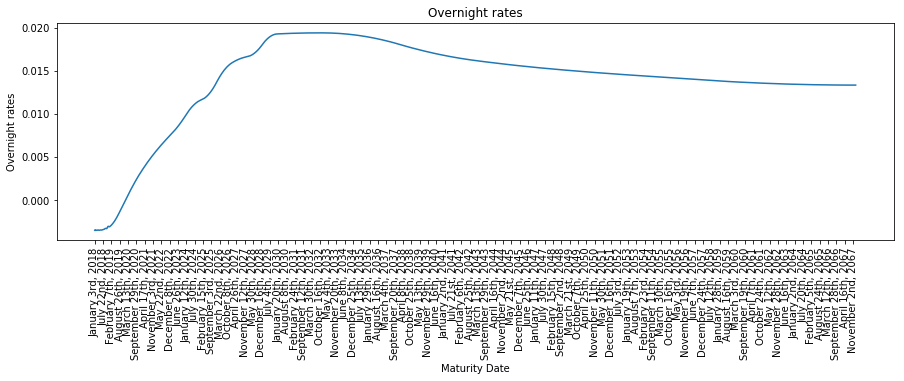

In [23]:
plt.figure(figsize=(15, 4))
plt.plot(accrual_factors, rates)
plt.xticks([d for d, s in zip(accrual_factors, mask_dates) if s], 
           [d for d, s in zip(dates, mask_dates) if s], rotation='vertical')
plt.xlabel('Maturity Date')
plt.ylabel('Overnight rates')
plt.title('Overnight rates')
plt.show()

### Stripped curve analysis

Compare zero rates and discount factors from the stripped curve with those from Bloomberg.

In [24]:
dates = []
dayCounter = ql.Actual360()

discounts = []
zero_coupons = []

for date in eonia_curve.dates():
    dates.append(date)
    discounts.append(eonia_curve.discount(date))
    zero_coupons.append(eonia_curve.zeroRate(date, dayCounter, ql.Compounded, ql.Annual).rate())
    
rates = pd.DataFrame(index = dates)
rates['Accrual Factor'] = [dayCounter.yearFraction(calculation_date, d) for d in dates]
rates["zero coupons"] = zero_coupons
rates["discounts"] = discounts

In [25]:
Bloomberg_eonia = pd.read_excel('Bloomberg data/EONIA/29 dec 2017/curve analysis/Stripped Curve.xlsx')

In [26]:
Bloomberg_eonia

,Payment Date,Maturity Date,Market Rate,Shift (bp),Shifted Rate,Zero Rate,Discount,Source
0,01/04/2018,01/04/2018,-0.346000,0,-0.346000,-0.346000,1.000010,CASH
1,01/11/2018,01/10/2018,-0.348000,0,-0.348000,-0.347407,1.000068,SWAP
2,01/18/2018,01/17/2018,-0.348000,0,-0.348000,-0.347419,1.000135,SWAP
3,02/06/2018,02/05/2018,-0.345000,0,-0.345000,-0.344460,1.000316,SWAP
4,03/06/2018,03/05/2018,-0.345500,0,-0.345500,-0.345005,1.000586,SWAP
5,04/04/2018,04/03/2018,-0.344500,0,-0.344500,-0.344055,1.000862,SWAP
6,05/04/2018,05/03/2018,-0.344700,0,-0.344700,-0.344304,1.001150,SWAP
7,06/05/2018,06/04/2018,-0.344300,0,-0.344300,-0.343958,1.001456,SWAP
8,07/04/2018,07/03/2018,-0.344000,0,-0.344000,-0.343706,1.001733,SWAP
9,08/06/2018,08/03/2018,-0.343000,0,-0.343000,-0.342758,1.002024,SWAP


In [27]:
rates['BBG zero coupons'] = [None] + list(0.01*Bloomberg_eonia['Zero Rate'])
rates['BBG discounts'] = [None] + list(Bloomberg_eonia['Discount'])

rates['error zero coupons'] = rates['BBG zero coupons'] - rates['zero coupons']
rates['error discounts'] = rates['BBG discounts'] - rates['discounts']

In [28]:
rates

,Accrual Factor,zero coupons,discounts,BBG zero coupons,BBG discounts,error zero coupons,error discounts
"January 3rd, 2018",0.013889,-0.003452,1.000000,NaN,NaN,NaN,NaN
"January 4th, 2018",0.016667,-0.003454,1.000010,-0.003460,1.000010,-5.962332e-06,4.440892e-15
"January 10th, 2018",0.033333,-0.003474,1.000068,-0.003474,1.000068,1.365613e-13,4.440892e-16
"January 17th, 2018",0.052778,-0.003474,1.000135,-0.003474,1.000135,-2.168404e-18,1.776357e-15
"February 5th, 2018",0.105556,-0.003445,1.000316,-0.003445,1.000316,-2.149374e-13,1.731948e-14
"March 5th, 2018",0.183333,-0.003450,1.000586,-0.003450,1.000586,4.070047e-13,-6.883383e-14
"April 3rd, 2018",0.263889,-0.003441,1.000862,-0.003441,1.000862,-1.372201e-13,3.619327e-14
"May 3rd, 2018",0.347222,-0.003443,1.001150,-0.003443,1.001150,1.797434e-13,-6.128431e-14
"June 4th, 2018",0.436111,-0.003440,1.001456,-0.003440,1.001456,-3.719551e-14,1.998401e-14
"July 3rd, 2018",0.516667,-0.003437,1.001733,-0.003437,1.001733,-1.965268e-14,1.154632e-14


Plot EONIA's Zero rates and discount factors 

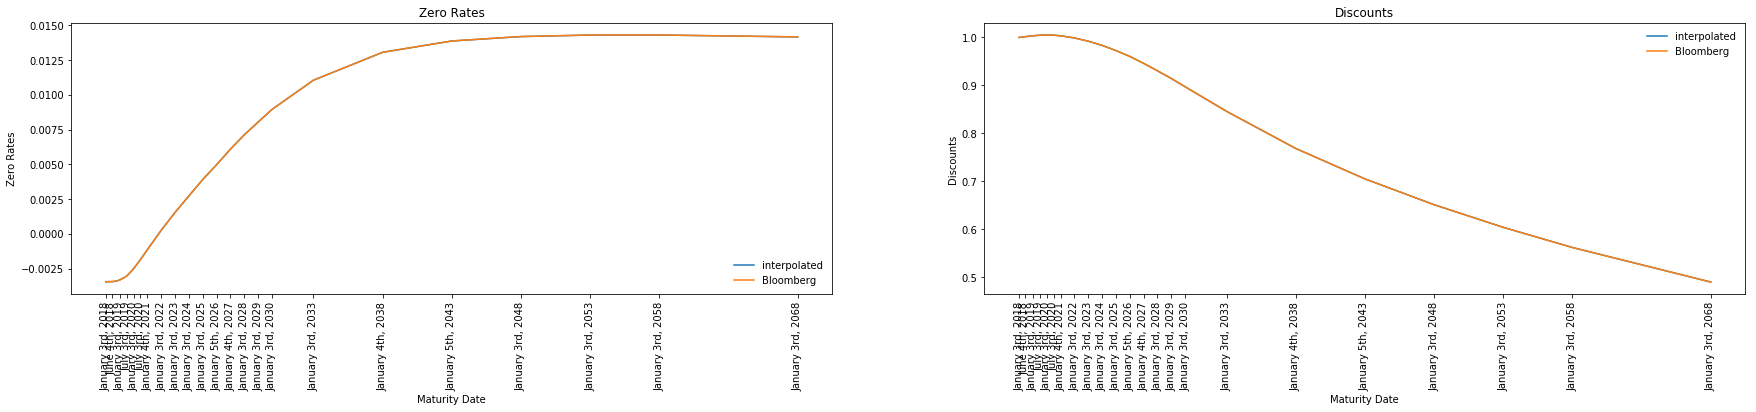

In [29]:
mask_dates = [True]*len(rates)

for i in range(1,15):
    mask_dates[i] = ((i%8)==0)

plt.figure(figsize=(30, 5))

plt.subplot(1, 2, 1)
plt.plot(rates['Accrual Factor'], rates['zero coupons'], label="interpolated")
plt.plot(rates['Accrual Factor'], rates['BBG zero coupons'], label='Bloomberg')
plt.xticks([d for d, s in zip(rates['Accrual Factor'], mask_dates) if s], 
           [d for d, s in zip(rates.index, mask_dates) if s], rotation='vertical')
plt.xlabel('Maturity Date')
plt.ylabel('Zero Rates')
plt.title('Zero Rates')
plt.legend(loc='lower right', frameon=False)

plt.subplot(1, 2, 2)
plt.plot(rates['Accrual Factor'], rates['discounts'], label="interpolated")
plt.plot(rates['Accrual Factor'], rates['BBG discounts'], label='Bloomberg')
plt.xticks([d for d, s in zip(rates['Accrual Factor'], mask_dates) if s], 
           [d for d, s in zip(rates.index, mask_dates) if s], rotation='vertical')
plt.xlabel('Maturity Date')
plt.ylabel('Discounts')
plt.title('Discounts')
plt.legend(loc='upper right', frameon=False)

plt.show()

Term structure handle

In [30]:
if enable_OIS_dual_curve_stripping:
    discountTermStructure.linkTo(eonia_curve)

## 2- Yield Curve bootstraping: EURIBOR 3M

We gather market quotes of several instruments from Bloomberg:
-  Short term (less than 3 months): <b>Deposits / Cash Rates</b>
-  Middle term (between 3 months and 1 year): For EURIBOR we can use either <b>Futures</b> or <b>FRAs</b>
-  Longterm (more than 1year): <b>Swaps</b>

In [31]:
if enable_OIS_dual_curve_stripping:
    if (mid_term_instrument == 'Futures'):
        zero_rates_chart = pd.read_excel('Bloomberg data/Yield curve - EURIBOR 3M/29 Dec 2017/dual-curve/with Futures/Yield curve construction/Zero Rates Chart.xlsx')
    elif (mid_term_instrument == 'FRAs'):
        zero_rates_chart = pd.read_excel('Bloomberg data/Yield curve - EURIBOR 3M/29 Dec 2017/dual-curve/with FRAs/Yield curve construction/Zero Rates Chart.xlsx')
else:
    if (mid_term_instrument == 'Futures'):
        zero_rates_chart = pd.read_excel('Bloomberg data/Yield curve - EURIBOR 3M/29 Dec 2017/mono-curve/with Futures/Yield curve construction/Zero Rates Chart.xlsx')
    elif (mid_term_instrument == 'FRAs'):
        zero_rates_chart = pd.read_excel('Bloomberg data/Yield curve - EURIBOR 3M/29 Dec 2017/mono-curve/with FRAs/Yield curve construction/Zero Rates Chart.xlsx')

In [32]:
zero_rates_chart

,Term,Unit,Ticker,Bid,Ask,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq
0,3,MO,EUR003M,-0.329000,-0.329000,NaN,0,0,-0.329000,-0.329000,Cash Rates,ACT/360,0
1,4,MO,EUFR0AD,-0.341000,-0.311000,NaN,0,0,-0.341000,-0.311000,Serial FRAs,ACT/360,0
2,5,MO,EUFR0BE,-0.339000,-0.309000,NaN,0,0,-0.339000,-0.309000,Serial FRAs,ACT/360,0
3,6,MO,EUFR0CF,-0.331000,-0.311000,NaN,0,0,-0.331000,-0.311000,Serial FRAs,ACT/360,0
4,7,MO,EUFR0DG,-0.321000,-0.311000,NaN,0,0,-0.321000,-0.311000,Serial FRAs,ACT/360,0
5,1,YR,EUSW1VC,-0.314548,-0.310452,NaN,0,0,-0.314548,-0.310452,Swap Rates,30U/360,1
6,2,YR,EUSW2V3,-0.212632,-0.207668,NaN,0,0,-0.212632,-0.207668,Swap Rates,30U/360,1
7,3,YR,EUSW3V3,-0.057317,-0.051683,NaN,0,0,-0.057317,-0.051683,Swap Rates,30U/360,1
8,4,YR,EUSW4V3,0.096410,0.102590,NaN,0,0,0.096410,0.102590,Swap Rates,30U/360,1
9,5,YR,EUSW5V3,0.235663,0.242337,NaN,0,0,0.235663,0.242337,Swap Rates,30U/360,1


In [33]:
zero_rates_chart['Unit'].replace({'MO': ql.Months, 'YR': ql.Years}, inplace=True)
zero_rates_chart['Daycount'] = zero_rates_chart['Daycount'].map({'ACT/360': ql.Actual360(), '30U/360': ql.Thirty360()})

Term formatting. Retrieve maturity dates.

In [34]:
def term_to_date(term, unit, calculation_date):
    if unit=='ACTDATE':
        return ql.Date(int(str(term)[6:]), int(str(term)[4:6]), int(str(term)[:4]))
    else :
        return calculation_date + ql.Period(int(term), int(unit))
    
zero_rates_chart.insert(loc = 2, column='Maturity Date', value=[term_to_date(zero_rates_chart.loc[i,'Term'],
                                                                                zero_rates_chart.loc[i,'Unit'],
                                                                                calculation_date)
                                                            for i in range(len(zero_rates_chart))])

Compute Accrual factor

In [35]:
zero_rates_chart.insert(loc = 3, column = 'Accrual Factor', 
                        value = [zero_rates_chart.loc[0, 'Daycount'].yearFraction(calculation_date,
                                                                                  zero_rates_chart.loc[i, 'Maturity Date'])
                                 for i in range(len(zero_rates_chart))])

Add <b>Mid</b> column. We will consider it as the instrument quote

In [36]:
zero_rates_chart.insert(loc=7, column='Mid', value=(zero_rates_chart['Bid'] + zero_rates_chart['Ask']) / 2)

Masks to retrieve Cash Rates, Futures, FRAs, Swaps

In [37]:
mask_deposits = (zero_rates_chart['Rate Type'] == 'Cash Rates')

if (mid_term_instrument == 'Futures'):
    mask_futures = (zero_rates_chart['Rate Type'] == 'Serial Futures')
elif (mid_term_instrument == 'FRAs'):
    mask_FRAs = (zero_rates_chart['Rate Type'] == 'Serial FRAs')
    
mask_swaps = (zero_rates_chart['Rate Type'] == 'Swap Rates')

Add convexity adjustment for Serial futures

In [38]:
def B(t1, t2):
    return (1 - np.exp(-mean_reversion_coefficient*(t2-t1)))/mean_reversion_coefficient

In [39]:
def convexity_adjustment(t1, t2):
    return ((B(t1, t2) / (t2-t1)) * 
            (B(t1, t2) * (1 - np.exp(-2*mean_reversion_coefficient*t1)) + 2*mean_reversion_coefficient*B(0, t1)**2 ) * 
            (volatility**2/(4*mean_reversion_coefficient)))

In [40]:
if (mid_term_instrument == 'Futures') & enable_convexity_adjustment:
    time_to_maturity = zero_rates_chart.loc[mask_futures, 'Maturity Date'] - calculation_date
    time_to_maturity_plus_months = (zero_rates_chart.loc[mask_futures, 'Maturity Date']+ ql.Period(3, ql.Months)) - calculation_date

    zero_rates_chart.insert(loc=14, column='Convexity adjustment', value=[None]*len(zero_rates_chart))
    # zero_rates_chart.loc[mask_futures, 'Convexity adjustment'] = (volatility**2)*time_to_maturity*time_to_maturity_plus_months/2
    zero_rates_chart.loc[mask_futures, 'Convexity adjustment'] = [convexity_adjustment(t1, t2) 
                                                                  for t1, t2 in zip(time_to_maturity, time_to_maturity_plus_months)]

In [41]:
zero_rates_chart

,Term,Unit,Maturity Date,Accrual Factor,Ticker,Bid,Ask,Mid,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq
0,3,2,"March 29th, 2018",0.250000,EUR003M,-0.329000,-0.329000,-0.329000,NaN,0,0,-0.329000,-0.329000,Cash Rates,Actual/360 day counter,0
1,4,2,"April 29th, 2018",0.336111,EUFR0AD,-0.341000,-0.311000,-0.326000,NaN,0,0,-0.341000,-0.311000,Serial FRAs,Actual/360 day counter,0
2,5,2,"May 29th, 2018",0.419444,EUFR0BE,-0.339000,-0.309000,-0.324000,NaN,0,0,-0.339000,-0.309000,Serial FRAs,Actual/360 day counter,0
3,6,2,"June 29th, 2018",0.505556,EUFR0CF,-0.331000,-0.311000,-0.321000,NaN,0,0,-0.331000,-0.311000,Serial FRAs,Actual/360 day counter,0
4,7,2,"July 29th, 2018",0.588889,EUFR0DG,-0.321000,-0.311000,-0.316000,NaN,0,0,-0.321000,-0.311000,Serial FRAs,Actual/360 day counter,0
5,1,3,"December 29th, 2018",1.013889,EUSW1VC,-0.314548,-0.310452,-0.312500,NaN,0,0,-0.314548,-0.310452,Swap Rates,30/360 (Bond Basis) day counter,1
6,2,3,"December 29th, 2019",2.027778,EUSW2V3,-0.212632,-0.207668,-0.210150,NaN,0,0,-0.212632,-0.207668,Swap Rates,30/360 (Bond Basis) day counter,1
7,3,3,"December 29th, 2020",3.044444,EUSW3V3,-0.057317,-0.051683,-0.054500,NaN,0,0,-0.057317,-0.051683,Swap Rates,30/360 (Bond Basis) day counter,1
8,4,3,"December 29th, 2021",4.058333,EUSW4V3,0.096410,0.102590,0.099500,NaN,0,0,0.096410,0.102590,Swap Rates,30/360 (Bond Basis) day counter,1
9,5,3,"December 29th, 2022",5.072222,EUSW5V3,0.235663,0.242337,0.239000,NaN,0,0,0.235663,0.242337,Swap Rates,30/360 (Bond Basis) day counter,1


Terms and market quotes

In [42]:
# Deposits, FRAs and swaps quotes are in fact percentages. We need to convert them. Futures are quoted as 100-rate

deposits = dict([((int(term), int(unit)), 0.01*mid) 
                 for term, unit, mid in zip(zero_rates_chart.loc[mask_deposits, 'Term'],
                                            zero_rates_chart.loc[mask_deposits, 'Unit'],
                                            zero_rates_chart.loc[mask_deposits, 'Mid'])])

if (mid_term_instrument == 'Futures'):
    futures = dict([(mat_date, 100 - mid) 
                    for mat_date, mid in zip(zero_rates_chart.loc[mask_futures, 'Maturity Date'],
                                             zero_rates_chart.loc[mask_futures, 'Mid'])])
    if enable_convexity_adjustment:
        convexity_adjustment = dict([(mat_date, conv_adj)
                                     for mat_date, conv_adj in zip(zero_rates_chart.loc[mask_futures, 'Maturity Date'],
                                                                   zero_rates_chart.loc[mask_futures, 'Convexity adjustment'])])

elif (mid_term_instrument == 'FRAs'):
    FRAs = dict([((int(start), int(end)), 0.01*mid) 
                 for start, end, mid in zip(zero_rates_chart.loc[np.roll(mask_FRAs,-1), 'Term'],
                                            zero_rates_chart.loc[mask_FRAs, 'Term'],
                                            zero_rates_chart.loc[mask_FRAs, 'Mid'])])

swaps = dict([((int(term), int(unit)), 0.01*mid) 
              for term, unit, mid in zip (zero_rates_chart.loc[mask_swaps, 'Term'],
                                          zero_rates_chart.loc[mask_swaps, 'Unit'],
                                          zero_rates_chart.loc[mask_swaps, 'Mid'])])

In [43]:
deposits

{(3, 2): -0.0032900000000000004}

In [44]:
if (mid_term_instrument == 'Futures'):
    print(futures)
elif (mid_term_instrument == 'FRAs'):
    print(FRAs)

{(3, 4): -0.0032599999010562903, (4, 5): -0.003239999860525135, (5, 6): -0.00320999994874001, (6, 7): -0.0031599999964237254}


In [45]:
if (mid_term_instrument == 'Futures') & enable_convexity_adjustment:
    print(convexity_adjustment)

In [46]:
swaps

{(1, 3): -0.0031250000000000002,
 (2, 3): -0.0021014997363090547,
 (3, 3): -0.00054499998688697807,
 (4, 3): 0.00099499970674514666,
 (5, 3): 0.0023899999260902352,
 (6, 3): 0.0036400002241134648,
 (7, 3): 0.0048274996876716608,
 (8, 3): 0.0059800004959106451,
 (9, 3): 0.0070500001311302211,
 (10, 3): 0.0080399999022483844,
 (11, 3): 0.008980000019073486,
 (12, 3): 0.0098199999332428001,
 (15, 3): 0.01180999279022215,
 (20, 3): 0.0136134958267212,
 (25, 3): 0.014308500289917002,
 (30, 3): 0.01459499835968015,
 (35, 3): 0.014719996452331501,
 (40, 3): 0.0148224973678589,
 (50, 3): 0.01462499618530275}

Convert them to Quote objects

In [47]:
for n,unit in deposits.keys():
    deposits[(n,unit)] = ql.SimpleQuote(deposits[(n,unit)])

if (mid_term_instrument == 'Futures'):
    for d in futures.keys():
        futures[d] = ql.SimpleQuote(futures[d])
elif (mid_term_instrument == 'FRAs'):
    for n,unit in FRAs.keys():
        FRAs[(n,unit)] = ql.SimpleQuote(FRAs[(n,unit)])

for n,unit in swaps.keys():
    swaps[(n,unit)] = ql.SimpleQuote(swaps[(n,unit)])

Retrieve accrual convention for each instrument type

In [48]:
deposits_dayCounter = zero_rates_chart.loc[mask_deposits, 'Daycount'].iloc[0]

if (mid_term_instrument == 'Futures'):
    futures_dayCounter = zero_rates_chart.loc[mask_futures, 'Daycount'].iloc[0]
elif (mid_term_instrument == 'FRAs'):
    FRAs_dayCounter = zero_rates_chart.loc[mask_FRAs, 'Daycount'].iloc[0]
    
swaps_dayCounter = zero_rates_chart.loc[mask_swaps, 'Daycount'].iloc[0]

In [49]:
print('Deposits: ', deposits_dayCounter)

if (mid_term_instrument == 'Futures'):
    print('Futures: ', futures_dayCounter)
elif (mid_term_instrument == 'FRAs'):
    print('FRAs: ', FRAs_dayCounter)
    
print('Swaps: ', swaps_dayCounter)

Deposits:  Actual/360 day counter
FRAs:  Actual/360 day counter
Swaps:  30/360 (Bond Basis) day counter


#### Build rate helpers

Rate Helpers in QuantLib are objects with a role to take a yield term structure as an input, compute the price of a market instrument that this yield term structure implies, and compare this implied value to a price quoted or traded in the market.

These Rate helpers will be used while bootstrapping / calibrating the yield term structure: the bootstrapping/calibration process simply iteratively tries to minimise the discrepancy between the implied and quoted prices of instruments contained in the rate helpers.

In [50]:
depositHelpers = [ql.DepositRateHelper(ql.QuoteHandle(deposits[(term, unit)]), ql.Period(term, unit), 
                                       settlementDays, calendar, ql.ModifiedFollowing, False, deposits_dayCounter)
                  for term, unit in deposits.keys()]

In [51]:
months = 3

if (mid_term_instrument == 'Futures'):
    if enable_convexity_adjustment:
        futuresHelpers = [ql.FuturesRateHelper(ql.QuoteHandle(futures[d]), d, months, calendar, ql.ModifiedFollowing, True,
                                               futures_dayCounter, ql.QuoteHandle(ql.SimpleQuote(conv_adj)))
                          for d, conv_adj in zip(futures.keys(), convexity_adjustment.values())]
    else:
        futuresHelpers = [ql.FuturesRateHelper(ql.QuoteHandle(futures[d]), d, months, calendar, ql.ModifiedFollowing, True,
                                               futures_dayCounter, ql.QuoteHandle(ql.SimpleQuote(0.0)))
                          for d in futures.keys()]
        
elif (mid_term_instrument == 'FRAs'):
    FRAHelpers = [ql.FraRateHelper(ql.QuoteHandle(FRAs[(start, end)]), start, end, settlementDays, calendar, 
                                   ql.ModifiedFollowing, False, FRAs_dayCounter)
                  for start, end in FRAs.keys()]    

In [52]:
fixedLegFrequency = ql.Annual
fixedLegAdjustment = ql.Unadjusted
fixedLegDayCounter = swaps_dayCounter
index = ql.Euribor3M(forwardTermStructure)

In [53]:
swapHelpers = [ql.SwapRateHelper(ql.QuoteHandle(swaps[(term,unit)]), ql.Period(term, unit), calendar, 
                                 fixedLegFrequency, fixedLegAdjustment, fixedLegDayCounter, index, 
                                 ql.QuoteHandle(), ql.Period(0, ql.Days), discountTermStructure, settlementDays)
                for term, unit in swaps.keys()]

In [54]:
if (mid_term_instrument == 'Futures'):
    helpers = depositHelpers + futuresHelpers + swapHelpers
elif (mid_term_instrument == 'FRAs'):
    helpers = depositHelpers + FRAHelpers + swapHelpers

### Iterative algorithm to retrieve discount factors:

We use a bootstrap method:
-  <b>Cash rates :</b> The discount factor is given by the simple spot rate $r_s$: $ DF(T_n) = \frac{1}{1+r_s(T_n)} $
-  <b>Futures / FRas :</b> They provide us with the simple forward rates $r_{sf}$ directly.Then, the discount factor is given by: $ \frac{DF(T_n)}{DF(T_{n-1})} = \frac{1}{1+r_{sf}(T_n - T_{n-1})} $
-  <b>Swaps :</b> the cashflow of each leg is the following
    -  <b>Fixed leg :</b> $ \sum_{i=1}^N{Nom_i.C.\delta_i.DF(T_i)} $
    -  <b>Floating leg:</b> $ \sum_{j=1}^{N'}{Nom_j.EURIBOR_f(T_{j-1}', T_j').\delta_j.DF(T_j')} $
    
    where:
    -  Nom: nominal value. Without amortisation, $Nom_i = Nom$  $\forall i$
    -  $C$:  the swap fixed rate
    -  $\delta_i$: the accrual factor / year fraction between $T_{i-1}$ and $T_i$ 
    -  DF($T_i$): the discount factor at $T_i$
    -  $EURIBOR_f(T_{j-1}', T_j')$: EURIBOR rate bteween $T_{j-1}'$ and $T_j'$. We replace it with the forward rate between $T_{j-1}'$ and $T_j'$:
     <center> $ EURIBOR_f(T_{j-1}', T_j') = \frac{1}{\delta_j}\left(\frac{DF(T_{j-1}')}{DF(T_j')} - 1\right) $ <center\>

Equalising the two legs, we get the formula of the discount factor at $T_N$:
-  Mono-curve setting: $ DF(T_N) = \frac{DF_{spot} - C\sum_{i=1}^{N-1}{\delta_iDF(T_i)}}{1+C\delta_N} $
-  Dual-curve setting: $ DF(T_N) = \frac{DF_{OIS}(T_{N'}')\cdot DF(T_{N'-1}')}{DF_{OIS}(T_{N'}') + C\sum_{i=1}^N{\delta_i\cdot DF_{OIS}(T_i)} - \sum_{j=1}^{N'-1}{\left(\frac{DF(T_{j-1}')}{DF(T_j')} - 1\right).DF_{OIS}(T_j')}} $
    
    This formula is valid for a non-amortising swap.

While bootstraping, if the previous $ DF(T_{i-1}) $ in not already computed previously, we use one of these several interpolation method:

-  <b>PiecewiseFlatForward :</b> Backward flat interpolation of Forward rate (the value between two nodes is the same as the value of the right node
-  <b>PiecewiseLinearForward :</b> Linear interpolation of Forward rate
-  <b>PiecewiseLinearZero :</b> Linear interpolation of Zero rate. It is the default interpolator used in Bloomberg
-  <b>PiecewiseCubicZero :</b> Smooth (cubic spline) interpolation of Zero rate
-  <b>PiecewiseLogCubicDiscount :</b> Log-cubic interpolation of discount rates 

In [55]:
#interpolation_method = 'Piecewise Linear Forward'
interpolation_method = 'Piecewise Flat Forward'
tolerance = 1e-05
enableExtrapolation = False

In [56]:
interpolation_method_switcher = {'Piecewise Flat Forward': ql.PiecewiseFlatForward(settlementDate, helpers, swaps_dayCounter),
                                 'Piecewise Linear Forward': ql.PiecewiseLinearForward(settlementDate, helpers, swaps_dayCounter),
                                 'Piecewise Linear Zero': ql.PiecewiseLinearZero(settlementDate, helpers, swaps_dayCounter),
                                 'Piecewise Cubic Zero': ql.PiecewiseCubicZero(settlementDate, helpers, swaps_dayCounter, [], [], tolerance),
                                 'Piecewise LogCubic Discount': ql.PiecewiseLogCubicDiscount(settlementDate, helpers, swaps_dayCounter, [], [], tolerance)
                                }

In [57]:
yield_curve = interpolation_method_switcher[interpolation_method]

if enableExtrapolation:
    yield_curve.enableExtrapolation()

End of yield curve construction.

Now we will compare Discount Factors, Zero rates and Forward rates from the stripped curve to those from Bloomberg's one. 

In [58]:
#rates_compound_method = 'Simple compounded'
rates_compound_method = 'Continuously compounded'

In [59]:
rates_compound_method_switcher = {'Simple compounded': ql.Compounded, 'Continuously compounded': ql.Continuous}

In [60]:
dates = []
dayCounter = ql.Actual360()

discounts = []
zero_coupons = []
forward_tenor = ql.Period(3, ql.Months)
forward_3M = []

for date in yield_curve.dates():
    dates.append(date)
    discounts.append(yield_curve.discount(date))
    zero_coupons.append(yield_curve.zeroRate(date, dayCounter, rates_compound_method_switcher[rates_compound_method], 
                                             ql.Annual).rate())
    
    try:
        forward_3M.append(yield_curve.forwardRate(date, calendar.advance(date, forward_tenor), dayCounter, ql.Simple).rate())
    except RuntimeError:
        forward_3M.append(None)   

rates = pd.DataFrame(index = dates)
rates["Accrual Factor"] = [dayCounter.yearFraction(calculation_date, d) for d in dates]
rates["zero coupons"] = zero_coupons
rates["discounts"] = discounts
rates["forward 3M"] = forward_3M

Comparison of zero rates and discount factors with those from Bloomberg (Piecewise linear zero interpolation)

In [61]:
if enable_OIS_dual_curve_stripping:
    if (mid_term_instrument == 'Futures'):
        Bloomberg_stripped_curve = pd.read_excel('Bloomberg data/Yield curve - EURIBOR 3M/29 Dec 2017/dual-curve/with Futures/Yield curve analysis/Step Forward Continuous/Stripped Curve.xlsx')
        Bloomberg_forward_analysis = pd.read_excel('Bloomberg data/Yield curve - EURIBOR 3M/29 Dec 2017/dual-curve/with Futures/Yield curve analysis/Step Forward Continuous/Forward Analysis.xlsx')

    elif (mid_term_instrument == 'FRAs'):
        Bloomberg_stripped_curve = pd.read_excel('Bloomberg data/Yield curve - EURIBOR 3M/29 Dec 2017/dual-curve/with FRAs/Yield curve analysis/Step Forward Continuous/Stripped Curve.xlsx')
        Bloomberg_forward_analysis = pd.read_excel('Bloomberg data/Yield curve - EURIBOR 3M/29 Dec 2017/dual-curve/with FRAs/Yield curve analysis/Step Forward Continuous/Forward Analysis.xlsx')
else:
    if (mid_term_instrument == 'Futures'):
        Bloomberg_stripped_curve = pd.read_excel('Bloomberg data/Yield curve - EURIBOR 3M/29 Dec 2017/mono-curve/with Futures/Yield curve analysis/Step Forward Continuous/Stripped Curve.xlsx')
        Bloomberg_forward_analysis = pd.read_excel('Bloomberg data/Yield curve - EURIBOR 3M/29 Dec 2017/mono-curve/with Futures/Yield curve analysis/Step Forward Continuous/Forward Analysis.xlsx')        
    elif (mid_term_instrument == 'FRAs'):
        Bloomberg_stripped_curve = pd.read_excel('Bloomberg data/Yield curve - EURIBOR 3M/29 Dec 2017/mono-curve/with FRAs/Yield curve analysis/Step Forward Continuous/Stripped Curve.xlsx')
        Bloomberg_forward_analysis = pd.read_excel('Bloomberg data/Yield curve - EURIBOR 3M/29 Dec 2017/mono-curve/with FRAs/Yield curve analysis/Step Forward Continuous/Forward Analysis.xlsx')

In [62]:
Bloomberg_stripped_curve

,Maturity Date,Market Rate,Shift (bp),Shifted Rate,Zero Rate,Discount,Source
0,04/03/2018,-0.329000,0,-0.329000,-0.329000,1.000823,CASH
1,05/03/2018,-0.326000,0,-0.326000,-0.325139,1.001085,FRA
2,06/04/2018,-0.324000,0,-0.324000,-0.326680,1.001381,FRA
3,07/03/2018,-0.321000,0,-0.321000,-0.324845,1.001636,FRA
4,08/03/2018,-0.316000,0,-0.316000,-0.321024,1.001894,FRA
5,01/03/2019,-0.312500,0,-0.312500,-0.312533,1.003135,SWAP
6,01/03/2020,-0.210150,0,-0.210150,-0.210311,1.004220,SWAP
7,01/04/2021,-0.054500,0,-0.054500,-0.054757,1.001646,SWAP
8,01/03/2022,0.099500,0,0.099500,0.099590,0.996026,SWAP
9,01/03/2023,0.239000,0,0.239000,0.239933,0.988089,SWAP


In [63]:
Bloomberg_forward_analysis

,Date,Zero Rate,Forward Rate,Non-DC Zero,Non-DC Fwd,Zero Diff (bp),Fwd Diff (bp)
0,01/03/2018,0.000000,-0.329000,0.000000,-0.329000,0.000000,0.000000
1,04/03/2018,-0.328594,-0.321000,-0.328594,-0.321000,0.000000,0.000000
2,07/03/2018,-0.326383,-0.293855,-0.326383,-0.293804,0.000000,-0.005143
3,10/03/2018,-0.317605,-0.291176,-0.317588,-0.291098,-0.001748,-0.007756
4,01/03/2019,-0.312533,-0.106548,-0.312500,-0.106475,-0.003289,-0.007259
5,04/03/2019,-0.271361,-0.106548,-0.271321,-0.106475,-0.004080,-0.007259
6,07/03/2019,-0.244101,-0.106548,-0.244055,-0.106475,-0.004622,-0.007259
7,10/03/2019,-0.224794,-0.106548,-0.224744,-0.106475,-0.005020,-0.007259
8,01/03/2020,-0.210311,0.251781,-0.210258,0.252130,-0.005319,-0.034903
9,04/03/2020,-0.158736,0.251781,-0.158650,0.252130,-0.008643,-0.034903


In [64]:
Bloomberg_forward_analysis['Date'] = [ql.Date(int(str(term)[3:5]), int(str(term)[:2]), 
                                              int(str(term)[6:])) for term in Bloomberg_forward_analysis['Date']]
Bloomberg_forward_analysis.set_index('Date', inplace=True)

In [65]:
rates.insert(loc = 2, column = 'BBG zero coupons', value = [None] + list(0.01*Bloomberg_stripped_curve['Zero Rate']))
rates.insert(loc = 3, column = 'errors zero coupons', value = rates['zero coupons'] - rates['BBG zero coupons'])
rates.insert(loc = 5, column = 'BBG discounts', value = [None] + list(Bloomberg_stripped_curve['Discount']))
rates.insert(loc = 6, column = 'errors discounts', value = rates['discounts'] - rates['BBG discounts'])
rates.insert(loc = 8, column = 'BBG forward 3M', value = 0.01*Bloomberg_forward_analysis['Forward Rate'])
rates.insert(loc = 9, column = 'errors forward', value = rates['forward 3M'] - rates['BBG forward 3M'])

In [66]:
rates

,Accrual Factor,zero coupons,BBG zero coupons,errors zero coupons,discounts,BBG discounts,errors discounts,forward 3M,BBG forward 3M,errors forward
"January 3rd, 2018",0.013889,-0.003291,NaN,NaN,1.000000,NaN,NaN,-0.003290,-0.003290,-2.457236e-15
"April 3rd, 2018",0.263889,-0.003291,-0.003290,-0.000001,1.000823,1.000823,5.107026e-15,-0.003236,-0.003210,-2.615552e-05
"May 3rd, 2018",0.347222,-0.003284,-0.003251,-0.000032,1.001095,1.001085,1.017007e-05,-0.003203,NaN,NaN
"June 4th, 2018",0.436111,-0.003275,-0.003267,-0.000008,1.001384,1.001381,2.319876e-06,-0.003060,NaN,NaN
"July 4th, 2018",0.519444,-0.003264,-0.003248,-0.000016,1.001651,1.001636,1.556032e-05,-0.002965,NaN,NaN
"August 3rd, 2018",0.602778,-0.003249,-0.003210,-0.000039,1.001915,1.001894,2.112488e-05,-0.002857,NaN,NaN
"January 3rd, 2019",1.027778,-0.003087,-0.003125,0.000038,1.003135,1.003135,1.546164e-08,-0.001080,-0.001065,-1.475039e-05
"January 3rd, 2020",2.041667,-0.002076,-0.002103,0.000027,1.004219,1.004220,-3.068201e-08,0.002533,0.002518,1.512801e-05
"January 4th, 2021",3.061111,-0.000539,-0.000548,0.000008,1.001645,1.001646,-1.456050e-06,0.005643,0.005568,7.498963e-05
"January 3rd, 2022",4.072222,0.000981,0.000996,-0.000015,0.996027,0.996026,1.151918e-06,0.008007,0.007899,1.085149e-04


In [67]:
def mae(spreads):
    non_null_spreads = [e for e, s in zip(spreads, ~(np.isnan(spreads))) if s]
    return sum([abs(x) for x in non_null_spreads]) / len(non_null_spreads)
def mse(spreads):
    non_null_spreads = [e for e, s in zip(spreads, ~(np.isnan(spreads))) if s]
    return sum([x**2 for x in non_null_spreads]) / len(non_null_spreads)

def max_e(spreads):
    non_null_spreads = [e for e, s in zip(spreads, ~(np.isnan(spreads))) if s]
    return max([abs(x) for x in non_null_spreads])

In [68]:
errors = pd.DataFrame(index=['mae', 'mse', 'max'], columns=['zeros coupons', 'discounts', 'forward'])

In [69]:
errors.loc['mae'] = (rates[['errors zero coupons', 'errors discounts', 'errors forward']].apply(func=mae, axis=0)).values
errors.loc['mse'] = (rates[['errors zero coupons', 'errors discounts', 'errors forward']].apply(func=mse, axis=0)).values
errors.loc['max'] = (rates[['errors zero coupons', 'errors discounts', 'errors forward']].apply(func=max_e, axis=0)).values

In [70]:
errors

,zeros coupons,discounts,forward
mae,0.000138258,1.21715e-05,0.000144036
mse,3.46013e-08,3.44967e-10,3.11996e-08
max,0.000333944,5.22796e-05,0.000299416


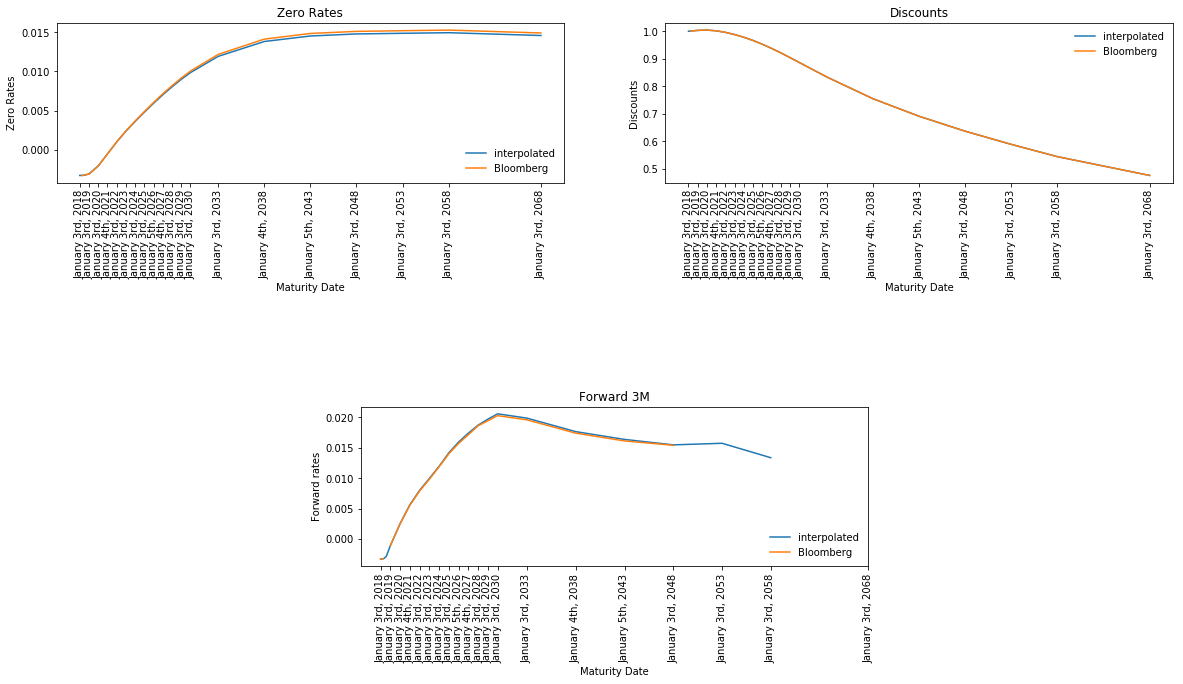

In [71]:
mask_dates = [True]*len(rates)

if (mid_term_instrument == 'Futures'):
    for i in range(1,21):
        mask_dates[i] = ((i%4)==0)

elif (mid_term_instrument == 'FRAs'):
    for i in range(1,6):
        mask_dates[i] = False
    
plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(3, 4)
gs.update(wspace=0.5)

plt.subplot(gs[0, :2])
plt.plot(rates['Accrual Factor'], rates['zero coupons'], label="interpolated")
plt.plot(rates['Accrual Factor'], rates['BBG zero coupons'], label='Bloomberg')
plt.xticks([d for d, s in zip(rates['Accrual Factor'], mask_dates) if s], 
           [d for d, s in zip(rates.index, mask_dates) if s], rotation='vertical')
plt.xlabel('Maturity Date')
plt.ylabel('Zero Rates')
plt.title('Zero Rates')
plt.legend(loc='lower right', frameon=False)

plt.subplot(gs[0, 2:])
plt.plot(rates['Accrual Factor'], rates['discounts'], label="interpolated")
plt.plot(rates['Accrual Factor'], rates['BBG discounts'], label='Bloomberg')
plt.xticks([d for d, s in zip(rates['Accrual Factor'], mask_dates) if s], 
           [d for d, s in zip(rates.index, mask_dates) if s], rotation='vertical')
plt.xlabel('Maturity Date')
plt.ylabel('Discounts')
plt.title('Discounts')
plt.legend(loc='upper right', frameon=False)

plt.subplot(gs[2, 1:3])
plt.plot(rates['Accrual Factor'], rates['forward 3M'], label="interpolated")
plt.plot(rates['Accrual Factor'], rates['BBG forward 3M'], label='Bloomberg')
plt.xticks([d for d, s in zip(rates['Accrual Factor'], mask_dates) if s], 
           [d for d, s in zip(rates.index, mask_dates) if s], rotation='vertical')
plt.xlabel('Maturity Date')
plt.ylabel('Forward rates')
plt.title('Forward 3M')
plt.legend(loc='lower right', frameon=False)

plt.show()

Term structure handles

In [72]:
if not(enable_OIS_dual_curve_stripping):
     discountTermStructure.linkTo(yield_curve)

forwardTermStructure.linkTo(yield_curve)

## 2- Swap pricing engine

In [73]:
swapEngine = ql.DiscountingSwapEngine(discountTermStructure)

### Swap setup

In [74]:
nominal = 10000000
length = ql.Period(5, ql.Years)
maturity = calendar.advance(settlementDate, length)
index = ql.Euribor3M(forwardTermStructure)
spread = 0.0
rule = ql.DateGeneration.Forward

# fixed leg
fixedLegFrequency = ql.Annual
fixedLegAdjustment = ql.Unadjusted
fixedLegDayCounter = ql.Thirty360()

marketfixedRate = swaps[length.length(), length.units()].value()
fixedRate = 0.04 

# floating leg
floatingLegFrequency = ql.Semiannual
floatingLegAdjustment = ql.ModifiedFollowing
floatingLegDayCounter = index.dayCounter()

In [75]:
print(index.dayCounter())

Actual/360 day counter


### Schedule setup

In [76]:
fixedSchedule = ql.Schedule(settlementDate, maturity, ql.Period(fixedLegFrequency), calendar, fixedLegAdjustment, 
                            fixedLegAdjustment, rule, False)

floatingSchedule = ql.Schedule(settlementDate, maturity, ql.Period(floatingLegFrequency), calendar, 
                               floatingLegAdjustment, floatingLegAdjustment, rule, False)

commonSchedule = np.sort(list(set(list(fixedSchedule) + list(floatingSchedule))))

In [77]:
commonSchedule

array([Date(3,1,2018), Date(3,7,2018), Date(3,1,2019), Date(3,7,2019),
       Date(3,1,2020), Date(3,7,2020), Date(3,1,2021), Date(4,1,2021),
       Date(5,7,2021), Date(3,1,2022), Date(4,7,2022), Date(3,1,2023)], dtype=object)

### Amortising swap setup (linear amortization)

In [78]:
notionals = [nominal * (1 - (d - settlementDate)/(maturity - settlementDate)) for d in commonSchedule]

amortisingSchedule = pd.DataFrame({'Term':commonSchedule, 'notionals': notionals})
amortisingSchedule.set_index('Term', inplace=True)

In [79]:
amortisingSchedule

,notionals
Term,
"January 3rd, 2018",1.000000e+07
"July 3rd, 2018",9.008762e+06
"January 3rd, 2019",8.001095e+06
"July 3rd, 2019",7.009858e+06
"January 3rd, 2020",6.002191e+06
"July 3rd, 2020",5.005476e+06
"January 3rd, 2021",3.997809e+06
"January 4th, 2021",3.992333e+06
"July 5th, 2021",2.995619e+06


In [80]:
fixed_leg_notionals = amortisingSchedule.loc[list(fixedSchedule), 'notionals'].values
floating_leg_notionals = amortisingSchedule.loc[list(floatingSchedule), 'notionals'].values

While building amortising swap legs, we have to discard the first notional's value (spot alue) in the amortisation schedule, since the first payment will occur in 1 year for the fixed leg and in 6 months for the floating leg.

In [81]:
amortising_fixed_leg = ql.FixedRateLeg(fixedSchedule, fixedLegDayCounter, fixed_leg_notionals[:-1], [fixedRate])
amortising_floating_leg = ql.IborLeg(floating_leg_notionals[:-1], floatingSchedule, index)

### Pricing Swaps

spot

In [82]:
#vanilla swap at market rate. It's spot value should be 0
market_rate_spot = ql.VanillaSwap(ql.VanillaSwap.Payer, nominal, fixedSchedule, marketfixedRate, fixedLegDayCounter, floatingSchedule, 
                      index, spread, floatingLegDayCounter)
market_rate_spot.setPricingEngine(swapEngine)

#vanilla swap
spot = ql.VanillaSwap(ql.VanillaSwap.Payer, nominal, fixedSchedule, fixedRate, fixedLegDayCounter, floatingSchedule, 
                      index, spread, floatingLegDayCounter)
spot.setPricingEngine(swapEngine)

#amortising swap
amortising_spot = ql.Swap(amortising_fixed_leg, amortising_floating_leg)
amortising_spot.setPricingEngine(swapEngine)

forward

In [83]:
#setup

horizon = ql.Period(1, ql.Years)

forwardStart = calendar.advance(settlementDate, horizon)
forwardEnd = calendar.advance(forwardStart, length, ql.Years)
forward_fixedSchedule = ql.Schedule(forwardStart, forwardEnd, ql.Period(fixedLegFrequency), calendar, 
                                    fixedLegAdjustment, fixedLegAdjustment, rule, False)
forward_floatingSchedule = ql.Schedule(forwardStart, forwardEnd, ql.Period(floatingLegFrequency), calendar, 
                                       floatingLegAdjustment, floatingLegAdjustment, rule, False)

#amortising legs

fixed_leg_notionals = [nominal * (1 - (d - settlementDate)/(maturity - settlementDate)) 
                       for d in forward_fixedSchedule]
floating_leg_notionals = [nominal * (1 - (d - settlementDate)/(maturity - settlementDate)) 
                          for d in forward_floatingSchedule]

amortized_fixed_leg = ql.FixedRateLeg(forward_fixedSchedule, fixedLegDayCounter, fixed_leg_notionals[:-1], [fixedRate])
amortized_floating_leg = ql.IborLeg(floating_leg_notionals[:-1], forward_floatingSchedule, index)

In [84]:
#vanilla swap
forward = ql.VanillaSwap(ql.VanillaSwap.Payer, nominal, forward_fixedSchedule, fixedRate, fixedLegDayCounter, 
                         forward_floatingSchedule, index, spread, floatingLegDayCounter)
forward.setPricingEngine(swapEngine)

#amortising swap
amortising_forward = ql.Swap(amortized_fixed_leg, amortized_floating_leg)
amortising_forward.setPricingEngine(swapEngine)

Format pricing engine output

In [85]:
# price on the bootstrapped curves

def formatPrice(p,digits=2):
    format = '%%.%df' % digits
    return format % p

def formatRate(r,digits=2):
    format = '%%.%df %%%%' % digits
    return format % (r*100)

headers = ("term structure", "net present value", "fixed leg NPV", "floating leg NPV", "fair spread", 
           "fair fixed rate" )
separator = " | "

format = ''
width = 0
for h in headers[:-1]:
    format += '%%%ds' % len(h)
    format += separator
    width += len(h) + len(separator)
format += '%%%ds' % len(headers[-1])
width += len(headers[-1])

rule = "-" * width
dblrule = "=" * width
tab = " " * 8

def report(swap, name):
    try:
        print (format % (name, formatPrice(swap.NPV(),2), formatPrice(swap.fixedLegNPV(),2), 
                         formatPrice(swap.floatingLegNPV(),2), formatRate(swap.fairSpread(),4), 
                         formatRate(swap.fairRate(),4)))
    except AttributeError:
        print (format % (name, formatPrice(swap.NPV(),2), formatPrice(swap.legNPV(0),2), 
                         formatPrice(swap.legNPV(1),2), None, None))

In [86]:
## Without amortisation

print (dblrule)
print ("5-year market swap-rate = %s" % formatRate(swaps[(5, ql.Years)].value()))
print (dblrule)

print (separator.join(headers))

print (rule)
print (tab + "5-years swap paying %s" % formatRate(marketfixedRate))
print (rule)

# price on spot swap
report(market_rate_spot,'depo-FRA-swap')

print (rule)
print (tab + "5-years swap paying %s" % formatRate(fixedRate))
print (rule)

# price on spot swap
report(spot,'depo-FRA-swap')

print (rule)
print (tab + "5-years, 1-year forward swap paying %s" % formatRate(fixedRate))
print (rule)

# price the 1-year forward swap
report(forward,'depo-FRA-swap')


## Amortising swap

print (dblrule)
print ("Amortising swap: 5-year market swap-rate = %s" % formatRate(marketfixedRate))
print (dblrule)

print (separator.join(headers))
print (rule)
print (tab + "5-years amortising swap paying %s" % formatRate(fixedRate))
print (rule)

# price on spot swap
report(amortising_spot,'depo-FRA-swap')

print (rule)
print (tab + "5-years, 1-year forward swap paying %s" % formatRate(fixedRate))
print (rule)

# price the 1-year forward swap
report(amortising_forward,'depo-FRA-swap')

5-year market swap-rate = 0.24 %
term structure | net present value | fixed leg NPV | floating leg NPV | fair spread | fair fixed rate
-----------------------------------------------------------------------------------------------------
        5-years swap paying 0.24 %
-----------------------------------------------------------------------------------------------------
 depo-FRA-swap |             15.76 |    -119575.06 |        119590.83 |   -0.0000 % |        0.2390 %
-----------------------------------------------------------------------------------------------------
        5-years swap paying 4.00 %
-----------------------------------------------------------------------------------------------------
 depo-FRA-swap |       -1881665.52 |   -2001256.34 |        119590.83 |    3.7054 % |        0.2390 %
-----------------------------------------------------------------------------------------------------
        5-years, 1-year forward swap paying 4.00 %
------------------------------

### Bloomberg SWPM

In [87]:
path = ''   

In [88]:
if enable_OIS_dual_curve_stripping:
    path += 'dual-curve/'
    if collateral:
        path += 'with collateral/'
    else:
        path += 'without collateral/'
else:
    path += 'mono-curve/'
    
if (mid_term_instrument == 'Futures'):
    path += 'with Futures/'
    if enable_convexity_adjustment:
        path += 'with convexity adjustment/'
    else:
        path += 'without convexity adjustment/'
elif (mid_term_instrument == 'FRAs'):
    path += 'with FRAs/'

-  #### No Amortisation

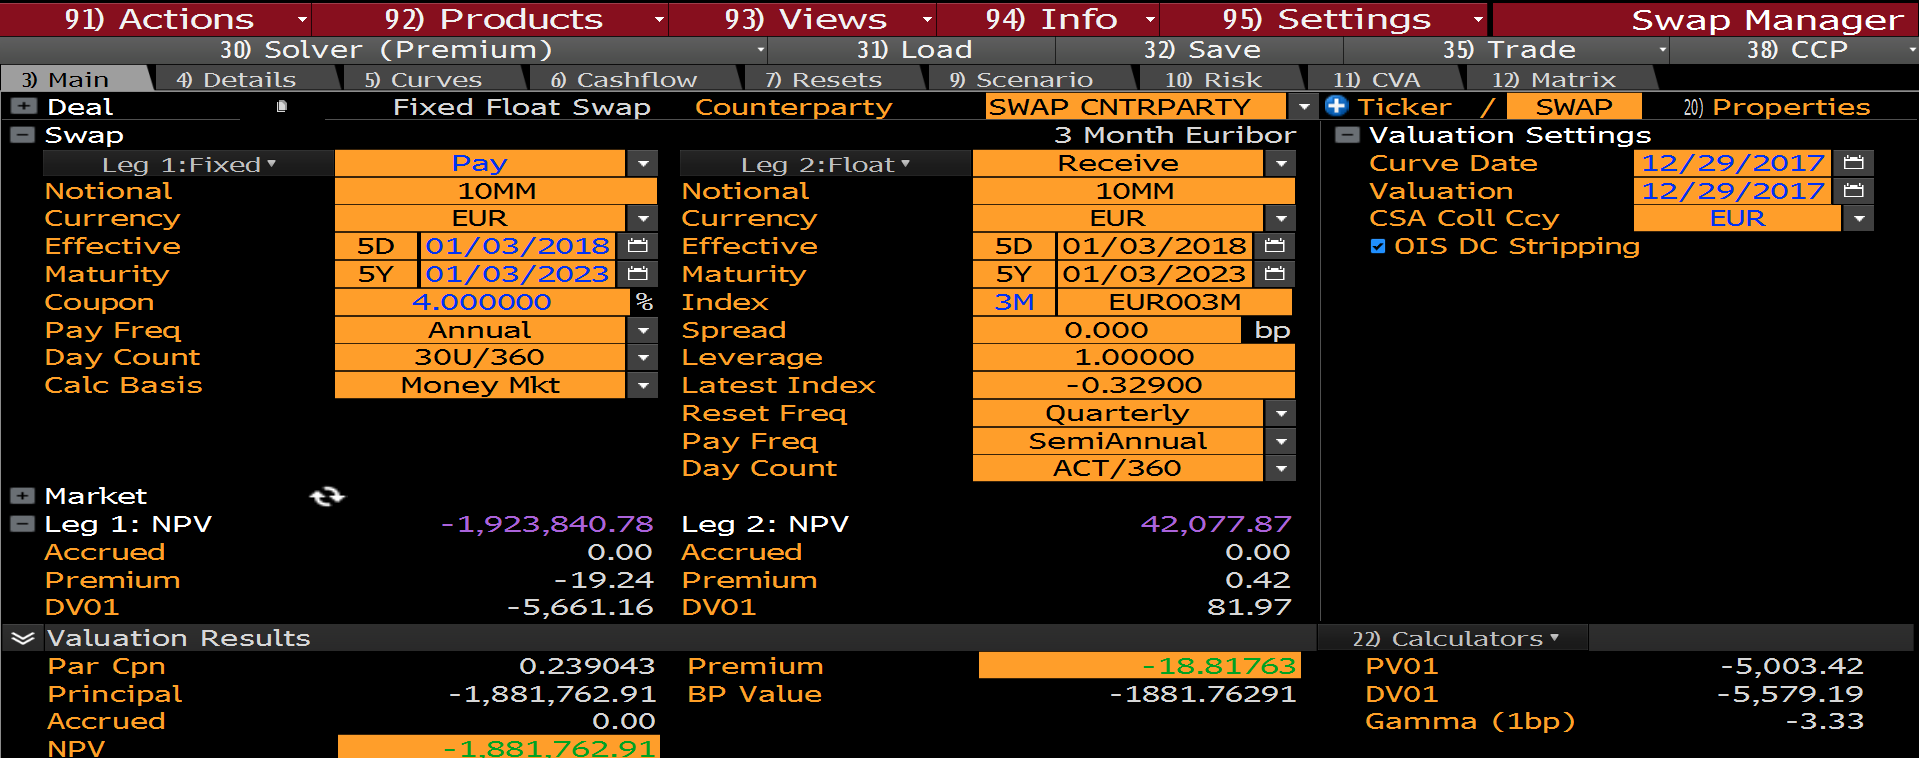

In [89]:
Image('SWPM/no amortisation/' + path + "Swap's details.PNG")

-  #### Amortisating swap

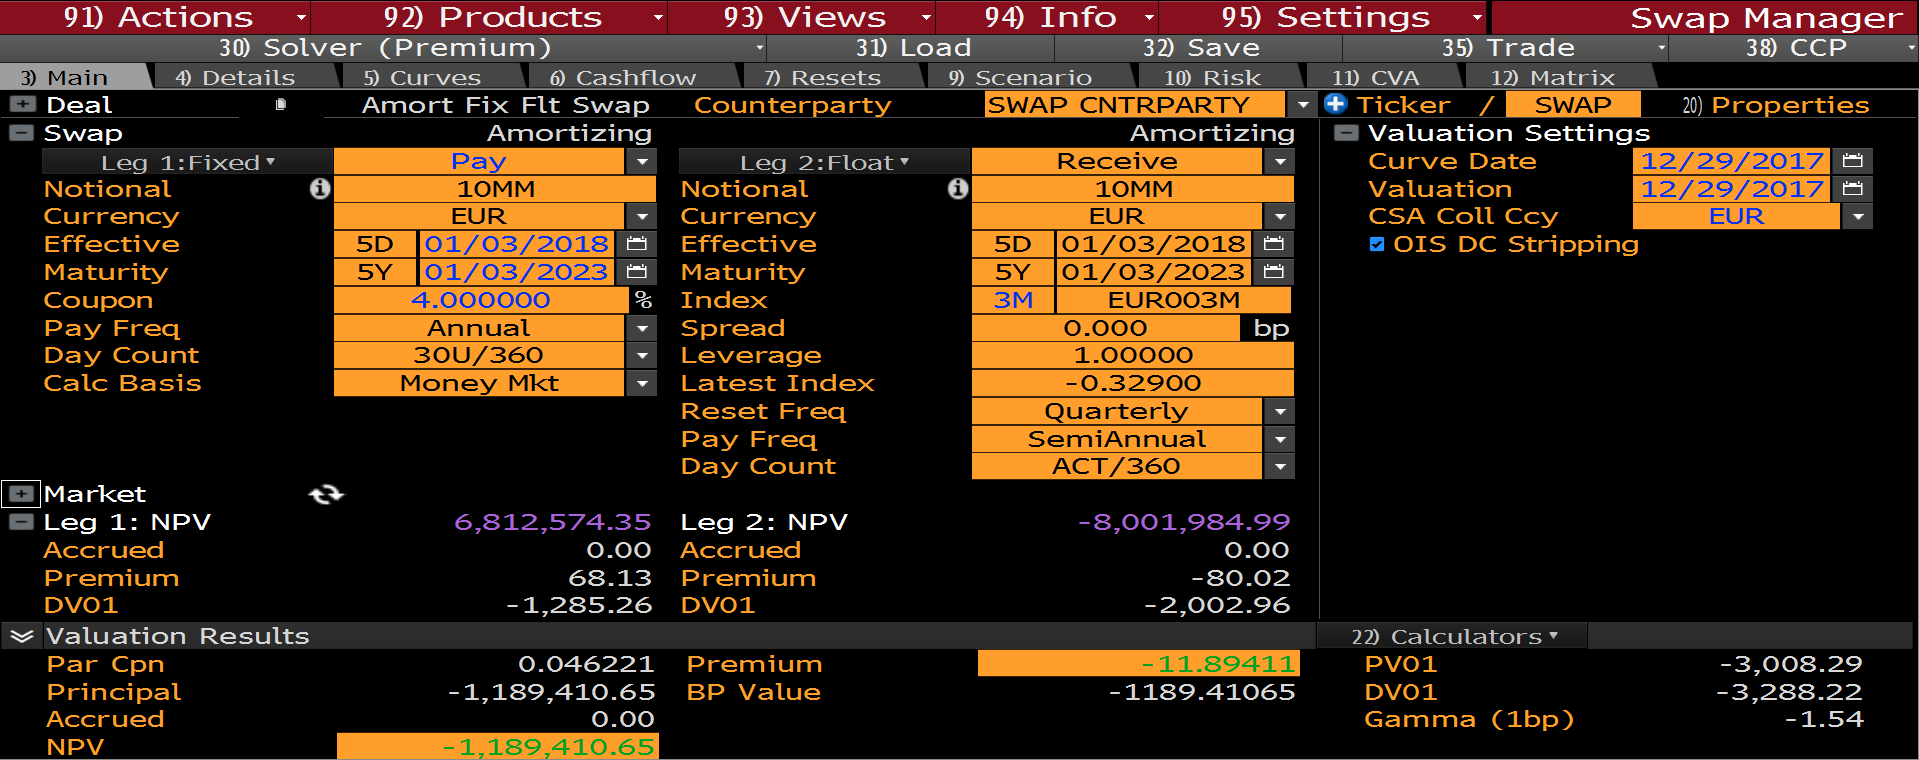

In [90]:
Image('SWPM/linear amortising swap/' + path + "Swap's details.PNG")

## Spot swap's cashflows

-  ### Without amortisation

In [91]:
cashflows_wo_amortisation = pd.DataFrame(columns=['Fixed Leg', 'Floating Leg'])

In [92]:
for i, cf in enumerate(spot.leg(0)):
    cashflows_wo_amortisation.set_value(index=cf.date(), col='Fixed Leg', value=cf.amount())
    
for i, cf in enumerate(spot.leg(1)):
    cashflows_wo_amortisation.set_value(index=cf.date(), col='Floating Leg', value=cf.amount())
    
cashflows_wo_amortisation.sort_index(inplace=True)

In [93]:
cashflows_wo_amortisation

,Fixed Leg,Floating Leg
"July 3rd, 2018",NaN,-16398.6
"January 3rd, 2019",400000,-14879.3
"July 3rd, 2019",NaN,-5400.43
"January 3rd, 2020",400000,-5400.43
"July 3rd, 2020",NaN,12809.5
"January 4th, 2021",400000,12880.7
"July 5th, 2021",NaN,28393.7
"January 3rd, 2022",400000,27922.4
"July 4th, 2022",NaN,40300
"January 3rd, 2023",400000,39853.8


In [94]:
cashflows_wo_amortisation.to_csv('cashflows_wo_amorisation.csv')

BBG's cashflows

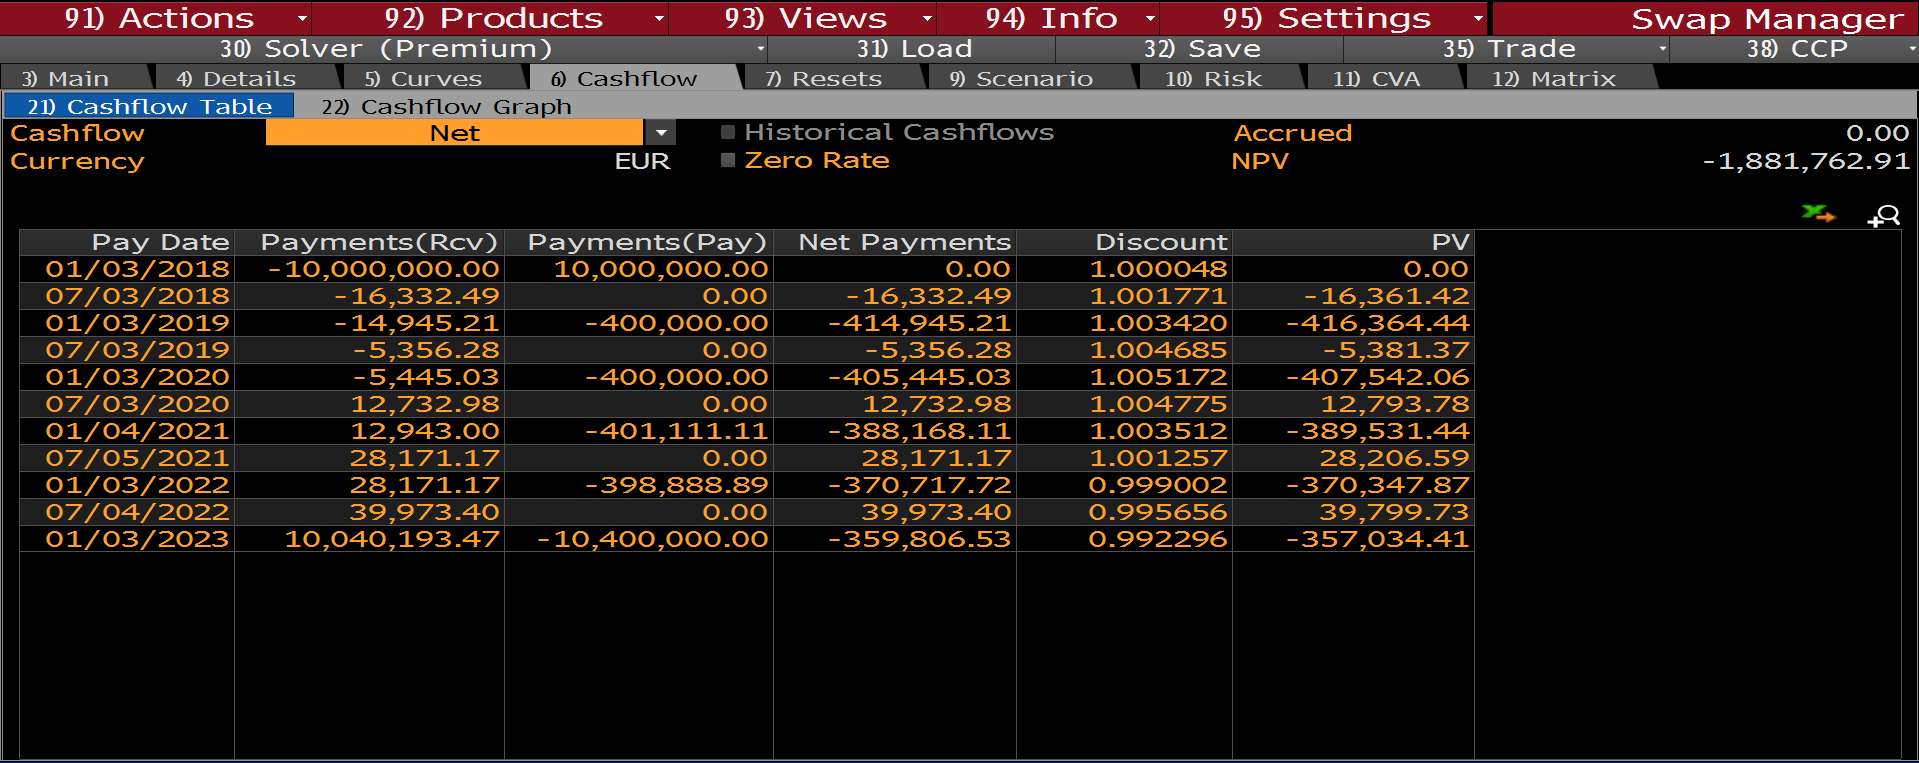

In [95]:
Image('SWPM/no amortisation/' + path + "Swap's cashflow.PNG")

-  ### With amortisation

In [96]:
cashflows_amortising_swap = pd.DataFrame(columns=['Fixed Leg', 'Floating Leg'])

In [97]:
for i, cf in enumerate(amortising_spot.leg(0)):
    cashflows_amortising_swap.set_value(index=cf.date(), col='Fixed Leg', value=cf.amount())
    
for i, cf in enumerate(amortising_spot.leg(1)):
    cashflows_amortising_swap.set_value(index=cf.date(), col='Floating Leg', value=cf.amount())
    
cashflows_amortising_swap.sort_index(inplace=True)

In [98]:
cashflows_amortising_swap

,Fixed Leg,Floating Leg
"July 3rd, 2018",NaN,-16398.6
"January 3rd, 2019",400000,-13404.4
"July 3rd, 2019",NaN,-4320.93
"January 3rd, 2020",320044,-3785.62
"July 3rd, 2020",NaN,7688.51
"January 4th, 2021",240088,6447.41
"July 5th, 2021",NaN,11335.7
"January 3rd, 2022",159912,8364.5
"July 4th, 2022",NaN,8055.59
"January 3rd, 2023",79956.2,3994.11


BBG's cashflows

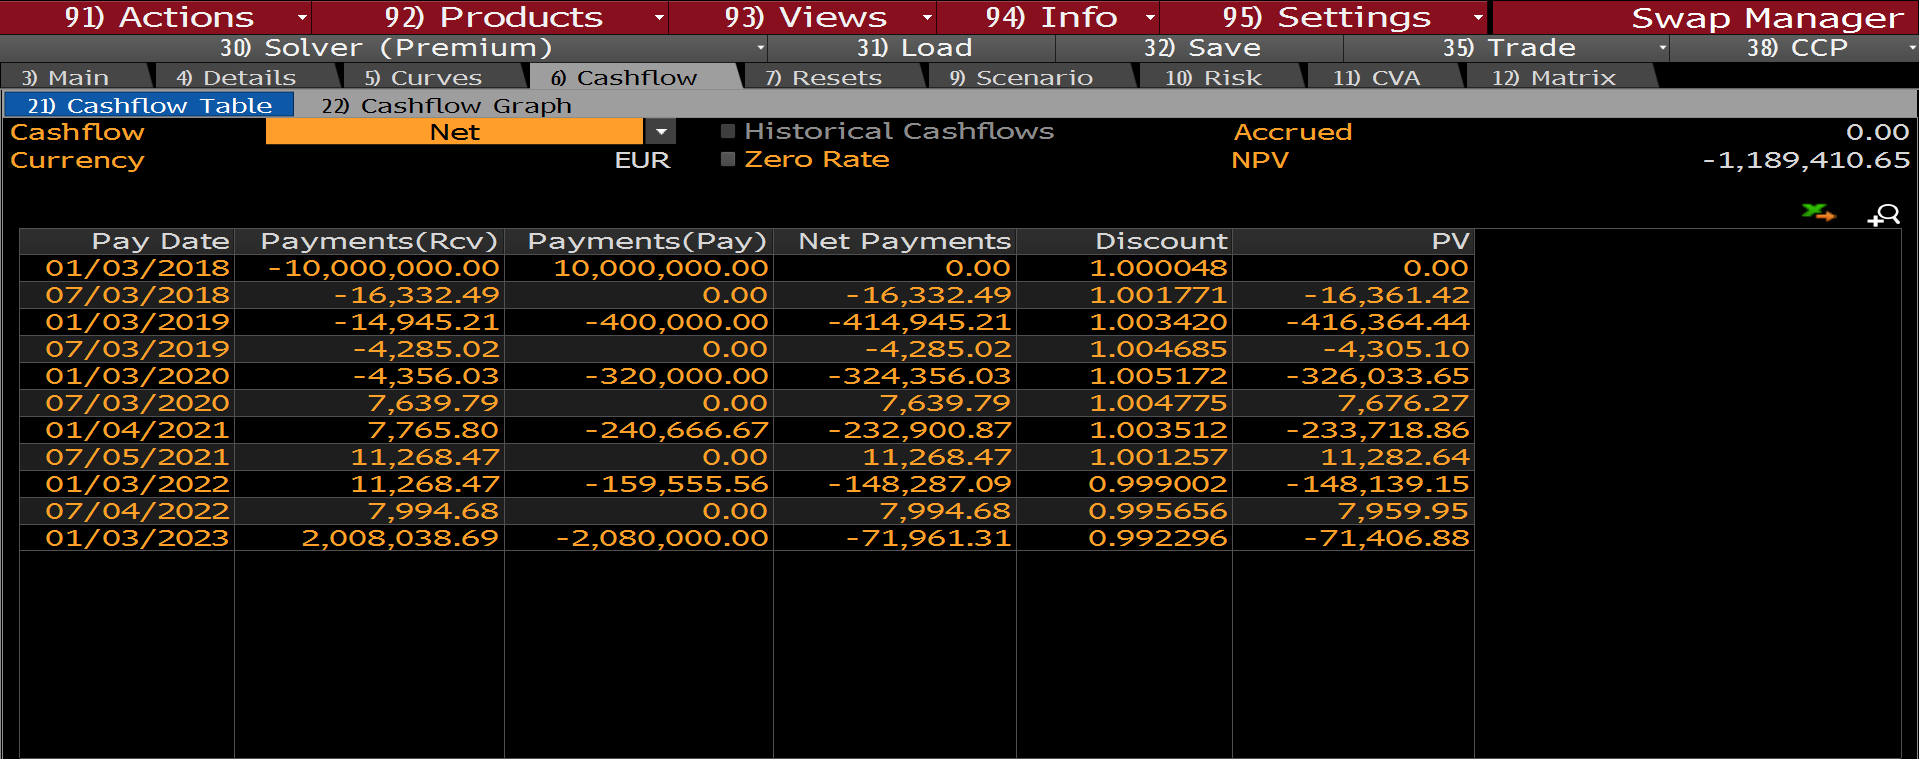

In [99]:
Image('SWPM/linear amortising swap/' + path + "Swap's cashflow.PNG")